<a href="https://colab.research.google.com/github/andremanhas/Pos_Data_Science/blob/main/TC4_Arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pmdarima

In [5]:
# Importação das bibliotecas utilizadas


import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima
import matplotlib.pyplot as plt
import numpy as np
import warnings
import xgboost as xgb
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [6]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [7]:
# Funções de Avaliação
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, mape


def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}")

In [8]:
# Leitura dos dados
series = pd.read_excel("ipeadata.xlsx")

# Converter a coluna de data para o formato datetime
series['data'] = pd.to_datetime(series['data'], format='%d/%m/%Y')
series.set_index('data', inplace=True)

# Data de início que você deseja filtrar
data_inicio = '2010-01-01'

# Filtrando os dados a partir da data de início
series = series.loc[data_inicio:]

# Exiba o DataFrame
print(series.head())

            preco
data             
2010-01-01  76.59
2010-01-02  76.65
2010-01-03  77.62
2010-01-04  77.91
2010-01-05  79.27


In [9]:
print(f"O dataset possui {series.shape[0]} linhas.")

O dataset possui 4703 linhas.


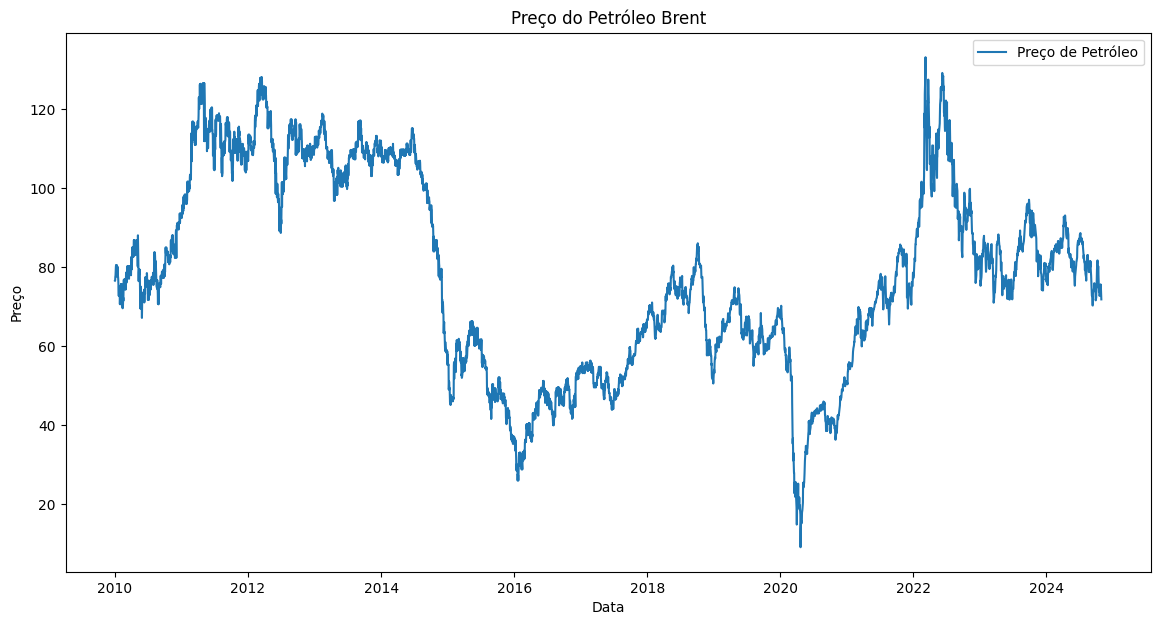

In [10]:
  # Visualização dos dados

plt.figure(figsize=(14, 7))
plt.plot(series["preco"], label="Preço de Petróleo")
plt.title("Preço do Petróleo Brent")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.legend()
plt.show()

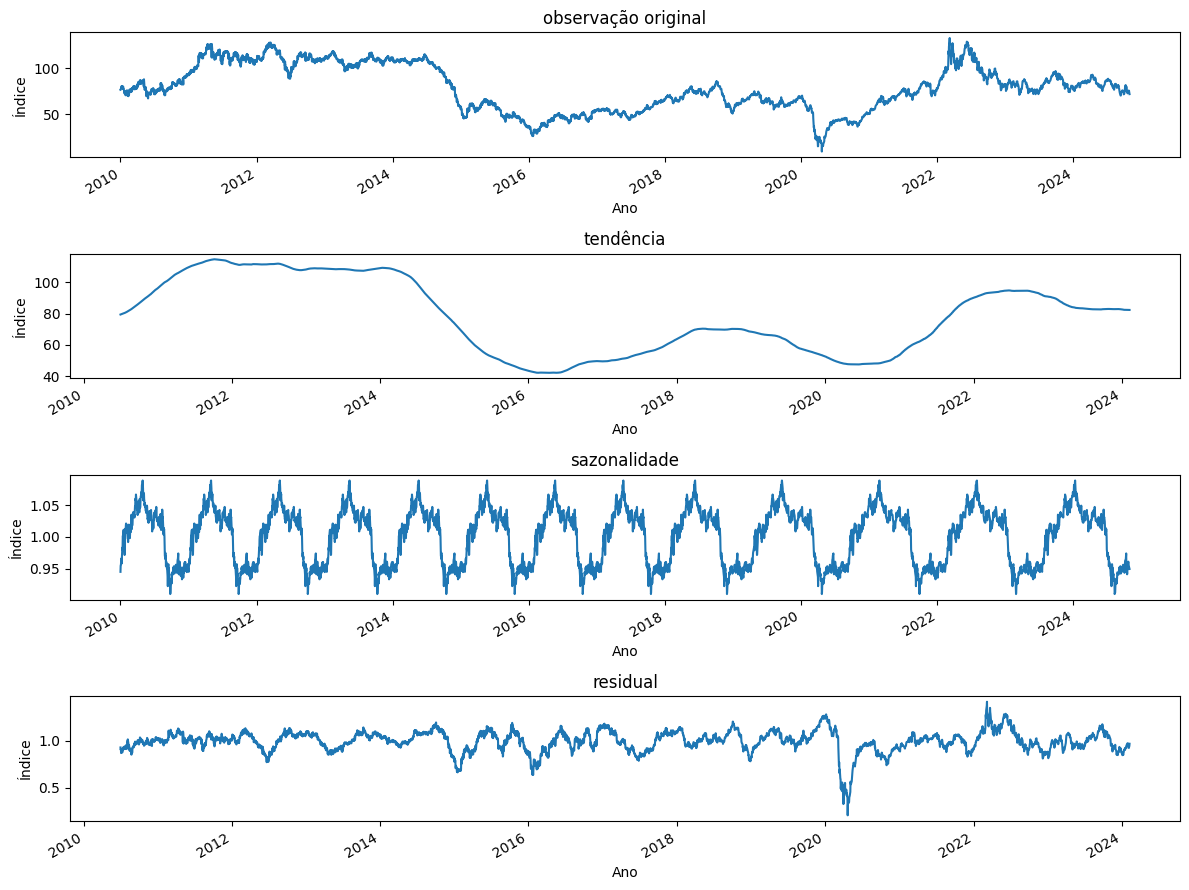

In [11]:
# Analisando os componentes da série temporal

result = seasonal_decompose(series["preco"], model="multiplicative", period=365)

fig, (ax1,ax2,ax3,ax4) = pyplot.subplots(4,1, figsize=(12,9))

result.observed.plot(ax=ax1, title="observação original", ylabel='Índice', xlabel='Ano')
result.trend.plot(ax=ax2, title="tendência", ylabel='Índice', xlabel='Ano')
result.seasonal.plot(ax=ax3, title="sazonalidade", ylabel='Índice', xlabel='Ano')
result.resid.plot(ax=ax4, title="residual", ylabel='Índice', xlabel='Ano')

pyplot.tight_layout()


Há presença de sazonalidade.

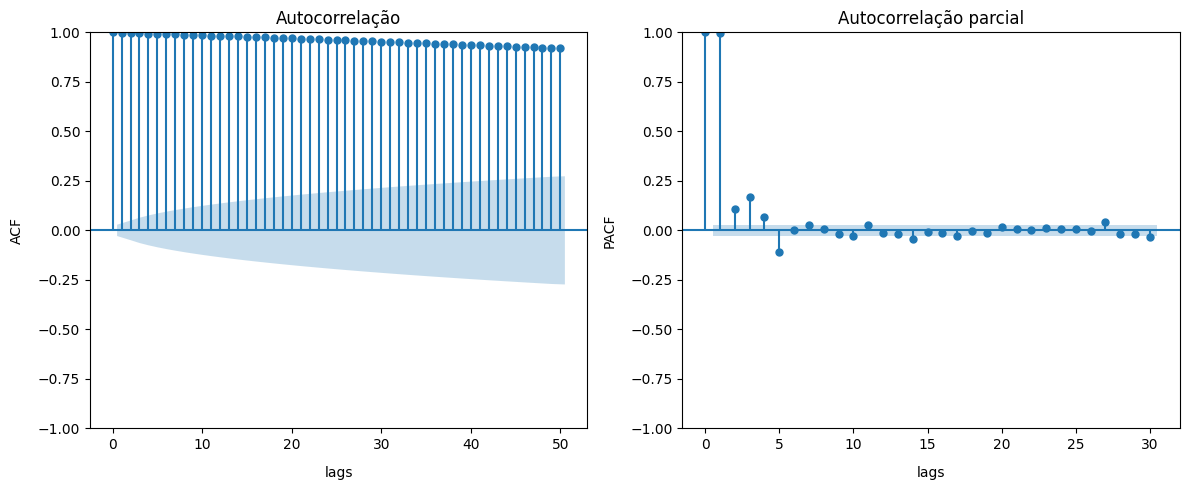

In [12]:
# Gráfico de autocorrelação total e parcial
fig, (ax1,ax2) = pyplot.subplots(1,2, figsize=(12,5))

plot_acf(series, ax=ax1, lags=50)
ax1.set_title('Autocorrelação')
ax1.set_ylabel('ACF', labelpad=10, fontsize=10)
ax1.set_xlabel('lags', labelpad=10, fontsize=10)

plot_pacf(series, ax=ax2, lags=30)
ax2.set_title('Autocorrelação parcial')
ax2.set_ylabel('PACF', labelpad=10, fontsize=10)
ax2.set_xlabel('lags', labelpad=10, fontsize=10)

pyplot.tight_layout()

Decaimento lento e com valores altos no ACF indica dependência de longo prazo (série não estacionária)

## Testar Estacionariesdade da Série

In [13]:
ad_fuller_test = sm.tsa.adfuller(series["preco"])

print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(ad_fuller_test[0]))
print('Valor-p: {:.4f}'.format(ad_fuller_test[1]))
print('Number of lags used: {:.4f}'.format(ad_fuller_test[2]))
print('Valores Críticos:')
for key, value in ad_fuller_test[4].items():
 print('\t{}: {:.4f}'.format(key, value))

teste = {("Não estacionária" if ad_fuller_test[0] > value else "Estacionária"): value for key, value in ad_fuller_test[4].items()}
print('O teste Dickey-Fuller Aumentado mostra que a série é: {}'.format(list(teste.keys())[0]))

Dickey-Fuller Aumentado
Teste Estatístico: -1.9385
Valor-p: 0.3142
Number of lags used: 13.0000
Valores Críticos:
	1%: -3.4317
	5%: -2.8622
	10%: -2.5671
O teste Dickey-Fuller Aumentado mostra que a série é: Não estacionária


 Faz-se necessário o uso da diferenciação para torná-la estacionária

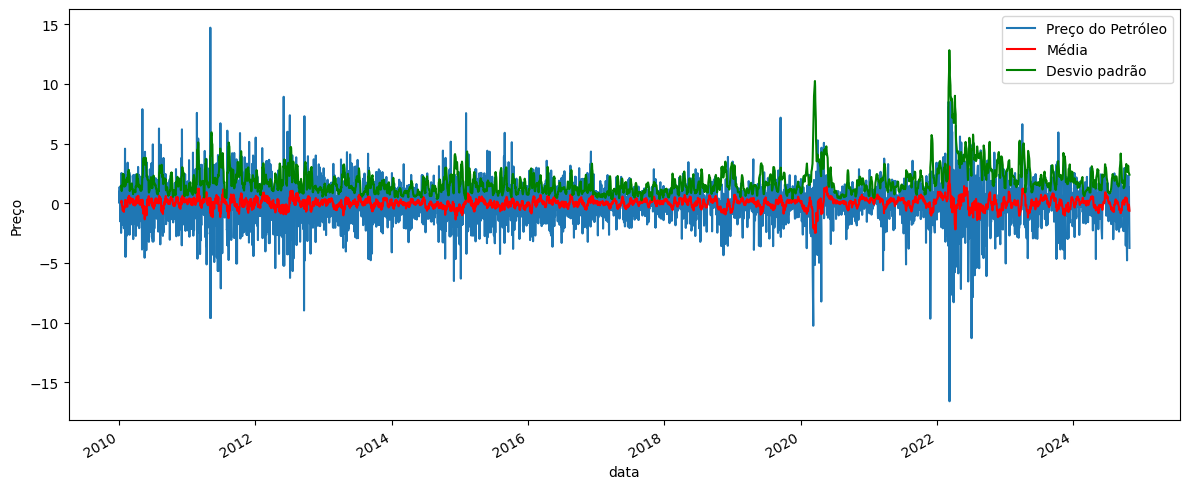

In [14]:
#aplicar diferenciação
df_diff = series.diff(1)
ma_diff = df_diff.rolling(12).mean()
ma_std = series.rolling(12).std()

#plotar a diferenciação
fig, ax = pyplot.subplots(figsize=(12,5))
df_diff.plot(ax=ax)
ma_diff.plot(ax=ax, color='r')
ma_std.plot(ax=ax, color='g')
ax.legend(['Preço do Petróleo', 'Média', 'Desvio padrão'])
ax.set_ylabel('Preço', fontsize=10)
pyplot.tight_layout()

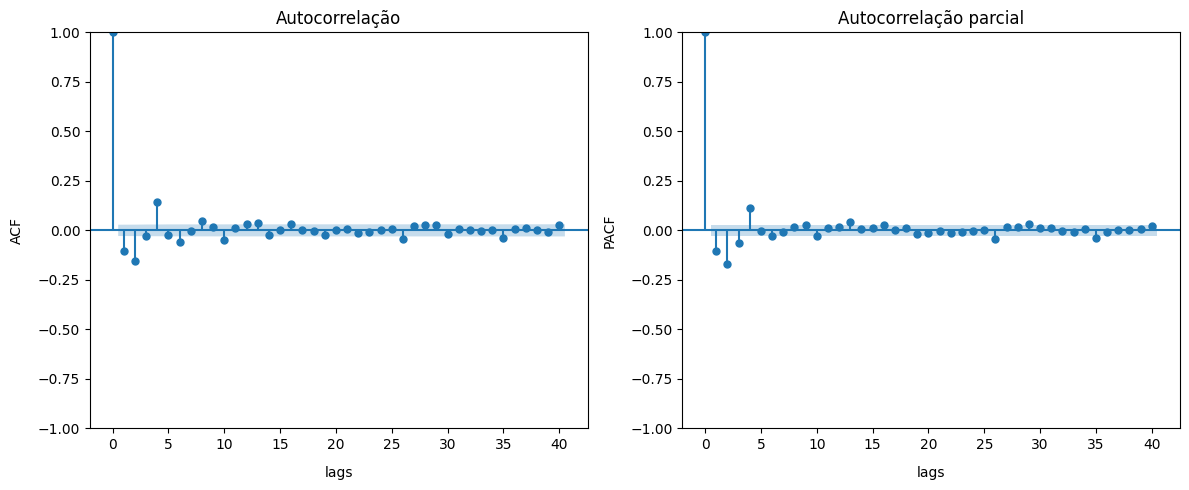

In [15]:
# Gráfico de autocorrelação total e parcial do índice de vendas após a diferenciação da série.

df_diff = series.diff(1)
series_after_diff = df_diff.dropna().values

fig, (ax1,ax2) = pyplot.subplots(1,2, figsize=(12,5))

plot_acf(series_after_diff, ax=ax1, lags=40)
ax1.set_title('Autocorrelação')
ax1.set_ylabel('ACF', labelpad=10, fontsize=10)
ax1.set_xlabel('lags', labelpad=10, fontsize=10)

plot_pacf(series_after_diff, ax=ax2, lags=40)
ax2.set_title('Autocorrelação parcial')
ax2.set_ylabel('PACF', labelpad=10, fontsize=10)
ax2.set_xlabel('lags', labelpad=10, fontsize=10)

pyplot.tight_layout()

Podemos observar agora que a série não apresenta lento decaimento em sua função de auto correlação como visto anteriormente. Podemos dizer nesse momento que a série temporal é estacionária. Mas para certificar, vamos executar novamente o teste Dickey-Fuller aumentado.

In [16]:
df_diff = series.diff(1)
series_after_diff = df_diff.dropna().values

ad_fuller_test = sm.tsa.adfuller(series_after_diff)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(ad_fuller_test[0]))
print('Valor-p: {:.4f}'.format(ad_fuller_test[1]))
print('Number of lags used: {:.4f}'.format(ad_fuller_test[2]))
print('Valores Críticos:')
for key, value in ad_fuller_test[4].items():
 print('\t{}: {:.4f}'.format(key, value))

teste = {("Não estacionária" if ad_fuller_test[0] > value else "Estacionária"): value for key, value in ad_fuller_test[4].items()}
print('O teste Dickey-Fuller Aumentado mostra que a série é: {}'.format(list(teste.keys())[0]))

Dickey-Fuller Aumentado
Teste Estatístico: -18.0397
Valor-p: 0.0000
Number of lags used: 12.0000
Valores Críticos:
	1%: -3.4317
	5%: -2.8622
	10%: -2.5671
O teste Dickey-Fuller Aumentado mostra que a série é: Estacionária


Ou seja, D = 1 (foi necesário somente uma diferenciação). Executamos nesse momento a função auto_arima para obter o melhor modelo ARIMA para previsão da série temporal.

##Arima

In [17]:
Arima_stepwise = auto_arima(series['preco'],
                          seasonal = False, #seasonal = False para obter um modelo ARIMA.
                          d = 1, #parâmetro de diferenciação da série.
                          trace = True,
                          error_action ='ignore',
                          suppress_warnings = True,
                          stepwise = True)

Arima_stepwise.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=18285.065, Time=10.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18522.983, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18472.873, Time=0.74 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18447.168, Time=1.85 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18520.985, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18355.863, Time=6.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18333.292, Time=4.76 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=18267.509, Time=11.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=18293.533, Time=2.91 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=18265.876, Time=6.99 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=18267.535, Time=3.25 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=18265.407, Time=12.67 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=18268.613, Time=8.60 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=18264.120, Time=21.82 sec
 ARIMA(4,1,3)(0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4703
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -9118.670
Date:                Sat, 16 Nov 2024   AIC                          18257.341
Time:                        15:19:41   BIC                          18321.898
Sample:                             0   HQIC                         18280.037
                               - 4703                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7262      0.071    -24.400      0.000      -1.865      -1.588
ar.L2         -1.5022      0.116    -12.905      0.000      -1.730      -1.274
ar.L3         -1.1409      0.090    -12.737      0.000      -1.317      -0.965
ar.L4         -0.5922      0.045    -13.218      0.000      -0.680      -0.504
ma.L1          1.6010      0.071     22.529      0.000       1.462       1.740
ma.L2          1.1516      0.111     10.349      0.000       0.933       1.370
ma.L3          0.7084      0.076      9.323      0.000       0.559       0.857
ma.L4          0.3588      0.039      9.304      0.000       0.283       0.434
ma.L5         -0.0446      0.020     -2.233      0.026      -0.084      -0.005
sigma2         2.8313      0.031     90.761      0.000       2.770       2.892
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6492.61
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.29
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Melhor modelo para o ARIMA (2,1,2)

In [18]:
arima_model = sm.tsa.arima.ARIMA(series, order=(2,1,2)).fit()
arima_model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  preco   No. Observations:                 4703
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9136.533
Date:                Sat, 16 Nov 2024   AIC                          18283.067
Time:                        15:19:43   BIC                          18315.345
Sample:                             0   HQIC                         18294.415
                               - 4703                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1690      0.041      4.145      0.000       0.089       0.249
ar.L2         -0.6105      0.032    -19.229      0.000      -0.673      -0.548
ma.L1         -0.2797      0.044     -6.364      0.000      -0.366      -0.194
ma.L2          0.4765      0.038     12.464      0.000       0.402       0.551
sigma2         2.8529      0.030     96.452      0.000       2.795       2.911
===================================================================================
Ljung-Box (L1) (Q):                   1.70   Jarque-Bera (JB):              7283.00
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -0.30
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

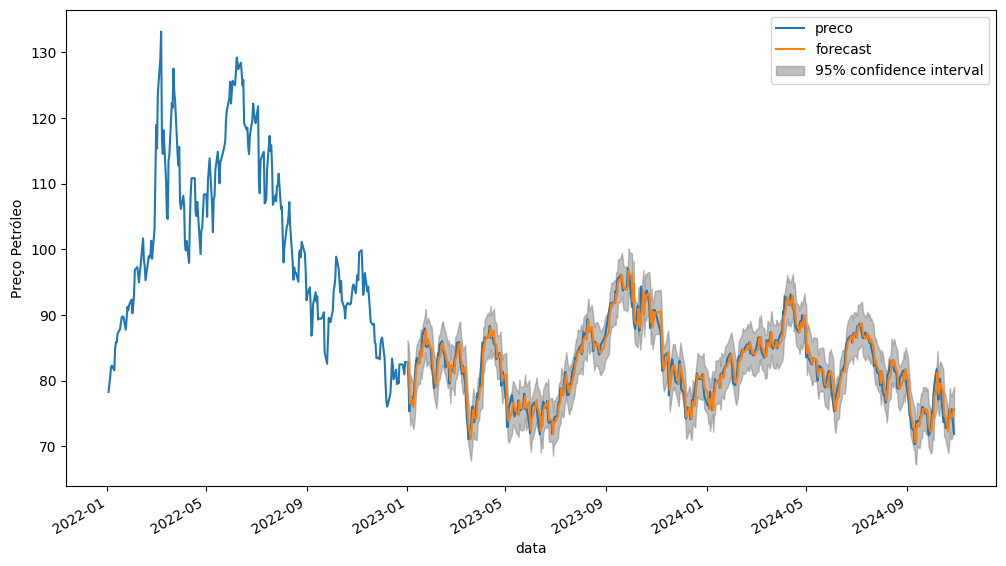

In [19]:
# Visualização do modelo:  ARIMA(0,1,1)

# Make sure the index is DatetimeIndex
series.index = pd.to_datetime(series.index)

fig, ax = pyplot.subplots(figsize=(12,7))
ax = series.loc['2022-01-01':].plot(ax=ax)
ax.set_ylabel('Preço Petróleo', fontsize=10)
ax.set_xlabel('Ano', fontsize=10)
plot_predict(arima_model, '2023-01-02', '2024-10-28', ax=ax)
pyplot.show()

In [20]:
# Dividindo em treino e teste

train_size = series.shape[0] - 14
train, test = series[0:train_size], series[train_size:]


In [21]:
Arima_stepwise = auto_arima(train['preco'],
                          seasonal = False, #seasonal = False para obter um modelo ARIMA.
                          d = 1, #parâmetro de diferenciação da série.
                          trace = True,
                          error_action ='ignore',
                          suppress_warnings = True,
                          stepwise = True)

Arima_stepwise.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=18226.360, Time=2.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18462.065, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18411.502, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18385.866, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18460.065, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18296.392, Time=1.86 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18274.255, Time=1.93 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=18208.392, Time=9.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=18234.034, Time=3.05 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=18206.497, Time=7.01 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=18208.044, Time=2.59 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=18206.102, Time=20.92 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=18209.161, Time=6.43 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=18204.802, Time=17.07 sec
 ARIMA(4,1,3)(0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4689
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -9089.852
Date:                Sat, 16 Nov 2024   AIC                          18199.703
Time:                        15:23:18   BIC                          18264.231
Sample:                             0   HQIC                         18222.393
                               - 4689                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5720      0.102    -15.452      0.000      -1.771      -1.373
ar.L2         -1.3604      0.120    -11.297      0.000      -1.596      -1.124
ar.L3         -1.0418      0.092    -11.374      0.000      -1.221      -0.862
ar.L4         -0.5412      0.056     -9.711      0.000      -0.650      -0.432
ma.L1          1.4468      0.102     14.198      0.000       1.247       1.647
ma.L2          1.0314      0.113      9.088      0.000       0.809       1.254
ma.L3          0.6504      0.074      8.738      0.000       0.504       0.796
ma.L4          0.3474      0.043      8.172      0.000       0.264       0.431
ma.L5         -0.0386      0.021     -1.796      0.072      -0.081       0.004
sigma2         2.8312      0.031     90.549      0.000       2.770       2.893
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6514.19
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.28
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
arima_model_1 = sm.tsa.arima.ARIMA(train["preco"], order=(4,1,5)).fit()
arima_model_1.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  preco   No. Observations:                 4689
Model:                 ARIMA(4, 1, 5)   Log Likelihood               -9089.852
Date:                Sat, 16 Nov 2024   AIC                          18199.703
Time:                        15:23:26   BIC                          18264.231
Sample:                             0   HQIC                         18222.393
                               - 4689                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5720      0.102    -15.452      0.000      -1.771      -1.373
ar.L2         -1.3604      0.120    -11.297      0.000      -1.596      -1.124
ar.L3         -1.0418      0.092    -11.374      0.000      -1.221      -0.862
ar.L4         -0.5412      0.056     -9.711      0.000      -0.650      -0.432
ma.L1          1.4468      0.102     14.198      0.000       1.247       1.647
ma.L2          1.0314      0.113      9.088      0.000       0.809       1.254
ma.L3          0.6504      0.074      8.738      0.000       0.504       0.796
ma.L4          0.3474      0.043      8.172      0.000       0.264       0.431
ma.L5         -0.0386      0.021     -1.796      0.072      -0.081       0.004
sigma2         2.8312      0.031     90.549      0.000       2.770       2.893
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6514.19
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.28
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
# Gerando previsões para o período de teste
# Defina o início e o fim das previsões no índice da série
start = len(train)
end = len(series) -1

# Previsão para o dataset de teste
preds = arima_model_1.predict(start=start, end=end, typ="levels")
preds.index = test.index  # Alinha o índice das previsões com o índice do conjunto de teste !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Exibindo as previsões
print(preds)

data
2024-10-09    78.322275
2024-10-10    78.890275
2024-10-11    79.230567
2024-10-12    78.642640
2024-10-15    78.547617
2024-10-16    78.834931
2024-10-17    78.940865
2024-10-18    78.800627
2024-10-21    78.629079
2024-10-22    78.823696
2024-10-23    78.839897
2024-10-24    78.804275
2024-10-25    78.728324
2024-10-28    78.773984
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


             Real   Previsão
data                        
2024-10-09  77.06  78.322275
2024-10-10  79.45  78.890275
2024-10-11  80.27  79.230567
2024-10-12  78.47  78.642640
2024-10-15  73.68  78.547617
2024-10-16  73.65  78.834931
2024-10-17  74.37  78.940865
2024-10-18  72.75  78.800627
2024-10-21  73.29  78.629079
2024-10-22  75.59  78.823696
2024-10-23  74.68  78.839897
2024-10-24  74.27  78.804275
2024-10-25  75.62  78.728324
2024-10-28  71.87  78.773984


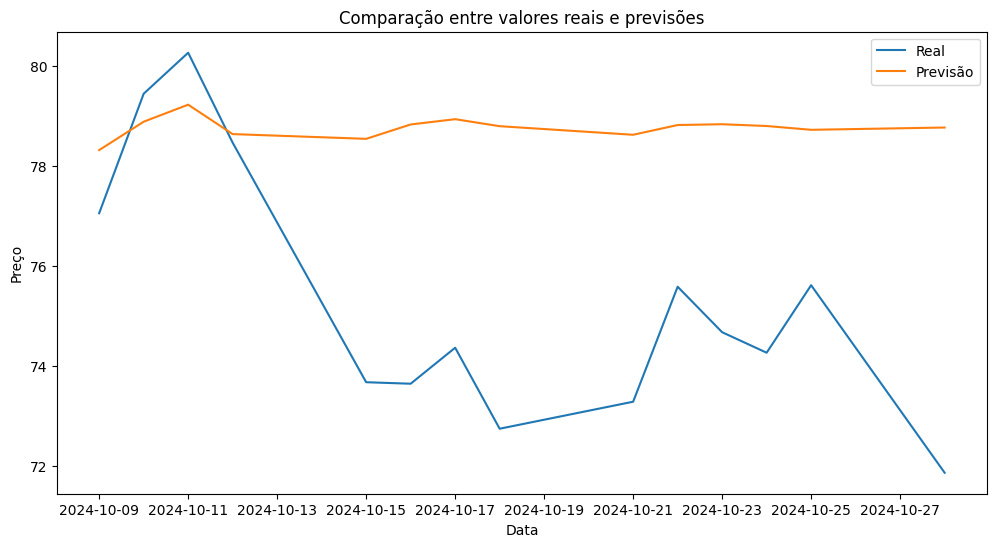

In [24]:
# Compare as previsões (preds) com os valores reais do conjunto de teste (test)
# Criando um DataFrame com as previsões e os valores reais lado a lado
comparison_df = pd.DataFrame({'Real': test['preco'], 'Previsão': preds})

# Imprima o DataFrame para comparar os valores
print(comparison_df)

# Além disso, você pode plotar as previsões junto com os valores reais para visualizar a qualidade do modelo.
plt.figure(figsize=(12, 6))
plt.plot(test['preco'], label='Real')
plt.plot(preds, label='Previsão')
plt.title('Comparação entre valores reais e previsões')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

In [25]:
# Avaliação ARIMA
metrics_arima = calculate_metrics(test["preco"], preds)
print("ARIMA Metrics:")
print_metrics(metrics_arima)

ARIMA Metrics:
MAE: 3.6419548788447926
MSE: 17.51789804142221
MAPE: 4.922991309511743


## SARIMA

In [ ]:
# Definir os parâmetros do SARIMA
p, d, q = 1, 1, 1
P, D, Q, m = 1, 1, 1, 365

# Ajustar o modelo SARIMA
model = SARIMAX(series, order=(p, d, q), seasonal_order=(P, D, Q, m))
sarima_result = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## XGBoost

Para melhorar a performance, vamos incluir uma nova coluna no dataset com o preço do dia anterior

In [ ]:
# Criando coluna preço dia anterior

series["preco_dia_anterior"] = series["preco"].shift(1)
series = series.drop(index=series.index[0])
print(series.head())

In [ ]:
# Dividindo em treino e teste

train_size = series.shape[0] - 14
train, test = series[0:train_size], series[train_size:]
print(test)

In [ ]:
# Preparação dos dados para XGBoost
df = series
def create_features(df):
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["day"] = df.index.day
    df["dayofweek"] = df.index.dayofweek
    return df


train = create_features(train)
test = create_features(test)

FEATURES = ["year", "month", "day", "dayofweek", "preco_dia_anterior"]
TARGET = "preco"

# Modelo XGBoost
X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(X_train, y_train)

# Avaliação XGBoost
preds = reg.predict(X_test)

metrics_xgb = calculate_metrics(y_test, preds)
print("XGBoost Metrics:")
print_metrics(metrics_xgb)

In [ ]:
# Criando um DataFrame com valores reais e previstos
comparison_df = pd.DataFrame({"Real": y_test, "Previsão": preds}, index=y_test.index)

# Plotando o gráfico de comparação
plt.figure(figsize=(14, 7))
plt.plot(comparison_df.index, comparison_df["Real"], label="Valor Real", color="blue")
plt.plot(comparison_df.index, comparison_df["Previsão"], label="Previsão", color="red", linestyle="--")
plt.title("Comparação entre Valores Reais e Previsões - XGBoost")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.legend()
plt.show()

## Prophet

In [ ]:
# Modelo Prophet
# Converter o índice de volta para uma coluna
train.reset_index(inplace=True)
test.reset_index(inplace=True)

train_prophet = train.rename(columns={"data": "ds", "preco": "y"})
test_prophet = test.rename(columns={"data": "ds", "preco": "y"})

# Criar o modelo Prophet
model = Prophet(daily_seasonality=True)

# Treinar o modelo Prophet
model.fit(train_prophet)

# Criar o dataframe de datas futuras para prever (o período do conjunto de teste)
future = test_prophet[["ds"]]

# Fazer previsões
forecast = model.predict(future)

# Extrair apenas as previsões para o conjunto de teste
preds = forecast[["ds", "yhat"]].iloc[-len(test):]

# Plotar os valores reais e as previsões
plt.figure(figsize=(12, 6))
plt.plot(test_prophet[["ds"]], test_prophet[["y"]], label="Valores Reais", color="blue")
plt.plot(preds[["ds"]], preds["yhat"], label="Previsões", color="red", linestyle="--")

# Título e legendas
plt.title("Valores Reais vs Previsões do Prophet")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.legend()

plt.show()

preds = preds.set_index("ds")
y_test = test_prophet.set_index("ds")["y"]

metrics_pr = calculate_metrics(y_test, preds["yhat"])
print("Prophet Metrics:")
print_metrics(metrics_pr)

## Prophet com preço do dia anterior

In [ ]:
print(test_prophet)

In [ ]:
# Criar o modelo Prophet
model = Prophet(daily_seasonality=True)
model.add_regressor("preco_dia_anterior")

# Treinar o modelo Prophet
model.fit(train_prophet)

# Criar o dataframe de datas futuras para prever (o período do conjunto de teste)
future = test_prophet[["ds", "preco_dia_anterior"]]

# Fazer previsões
forecast = model.predict(future)

# Extrair apenas as previsões para o conjunto de teste
preds = forecast[["ds", "yhat"]].iloc[-len(test):]

# Plotar os valores reais e as previsões
plt.figure(figsize=(12, 6))
plt.plot(test_prophet[["ds"]], test_prophet[["y"]], label="Valores Reais", color="blue")
plt.plot(preds[["ds"]], preds["yhat"], label="Previsões", color="red", linestyle="--")

# Título e legendas
plt.title("Valores Reais vs Previsões do Prophet")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.legend()

plt.show()

preds = preds.set_index("ds")
y_test = test_prophet.set_index("ds")["y"]

metrics_pr_2 = calculate_metrics(y_test, preds["yhat"])
print("Prophet Metrics:")
print_metrics(metrics_pr_2)

In [ ]:
print(preds)

In [ ]:
df = pd.DataFrame(
    [metrics_arima, metrics_xgb, metrics_pr, metrics_pr_2],
    columns=["MAE", "MSE", "MAPE"],
    index=["Arima", "XGBoost", "Prophet", "Prophet 2"],
)
df